In [230]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

In [231]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import random
from sklearn.covariance import LedoitWolf, OAS
import matplotlib.pyplot as plt
import matplotlib.cm as mpl
#import seaborn as sns
import statsmodels.api as sm
from multipy.fdr import qvalue
from multipy.fdr import lsu

In [232]:
from trim_networks import *
from fit_sbm import *

In [233]:
def FilterByGraph(g, g_ref):
    genes = g.vp.genes

    keep = g.new_vertex_property("bool", True)
    for v in g.get_vertices():
        if genes[v] not in g_ref.vp.genes:
            keep[v] = False
    tv = GraphView(g, vfilt=keep)
    g = Graph(tv, prune = True)
    return g


def KeepRandomVertices(g, num_vertices_to_keep):
    keep = g.new_vertex_property("bool")
    vertices = list(g.get_vertices())
    
    # Select a random subset of vertices
    subset_vertices = np.random.choice(vertices, num_vertices_to_keep, replace=False) 
    
    # Mark the selected vertices to keep
    for v in subset_vertices:
        keep[v] = True
    
    # Create a new graph view with the filtered vertices
    tv = GraphView(g, vfilt=keep)
    
    # Create a new graph from the graph view and prune unused vertices
    g_subset = Graph(tv, prune=True)
    
    return g_subset


def KeepRandomSubset(g, subset_ratio):
    keep = g.new_vertex_property("bool")
    vertices = list(g.get_vertices())
    num_vertices = len(vertices)
    num_subset = int(num_vertices * subset_ratio)
    
    # Select a random subset of vertices
    subset_vertices = np.random.choice(vertices, num_subset, replace=False)
    
    # Mark the selected vertices to keep
    for v in subset_vertices:
        keep[v] = True
    
    # Create a new graph view with the filtered vertices
    tv = GraphView(g, vfilt=keep)
    
    # Create a new graph from the graph view and prune unused vertices
    g_subset = Graph(tv, prune=True)
    
    return g_subset

In [234]:
folder = "../data/output/SBM/graphs/"
fdr_list = [0.5, 0.25, 1e-1, 5e-2, 1e-2]
#fdr_list = [0.25, 1e-1]
iter = 1000
nodes = 300
seed = 0

In [235]:
output_folder = "FDRplots/" + "nodes-" + str(nodes) + "/" + "seed-" + str(seed) + "/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
plot_folder = os.path.join(output_folder, "plots/")
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
graph_folder = os.path.join(output_folder, "graphs/")
if not os.path.exists(graph_folder):
    os.makedirs(graph_folder)

# Check if the file exists
if os.path.exists(output_folder + "SBM_head_" + str(nodes) + "_vertices.xml.gz"):
    # If it does, load the graph from the file
    print("Loading small head graph")
    g_total = load_graph(output_folder + "SBM_head_" + str(nodes) + "_vertices.xml.gz")
else:
    print("Loading head graph")
    g_head = load_graph(folder + "VOOMCounts_CPM1_head_ctrl_248ind_counts3M_covfree_Aug3121.xml.gz")
    # Filter the graph to keep only the top 150 vertices
    print("Filtering graph vertices")
    np.random.seed(seed)
    g_total = KeepRandomVertices(g_head, nodes)
    g_total.save(output_folder + "SBM_head_" + str(nodes) + "_vertices.xml.gz")

    corr = g_total.edge_properties["spearman"]
    g_total.ep.weight = g_total.new_edge_property("double", (2*np.arctanh(corr.a)))

g = {}
for i in fdr_list:
    if os.path.exists(graph_folder + "SBM_FDR-" + str(i) +  "_graph.xml.gz"):
        print("Loading graph for FDR = " + str(i))
        g[i] = load_graph(graph_folder + "SBM_FDR-" + str(i) +  "_graph.xml.gz")
    else:
        print("Filtering graph by FDR")
        for fdr in fdr_list:
            g[fdr] = filterByFDR(g_total, fdr, True)

        print("Filtering by smallest graph")
        for i in fdr_list:
            g[i] = FilterByGraph(g[i], g[fdr_list[-1]])



print("Calculating layout")
pos = arf_layout(g[fdr_list[-1]])


Loading small head graph
Loading graph for FDR = 0.5
Loading graph for FDR = 0.25
Loading graph for FDR = 0.1
Loading graph for FDR = 0.05
Loading graph for FDR = 0.01
Calculating layout


In [257]:
state = {}
for i in fdr_list:

    if os.path.exists(graph_folder + "SBM_FDR-" + str(i) +  "_blocks.dill"):
        print("Loading block state for FDR: ", i)
        with open(graph_folder + "SBM_FDR-" + str(i) +  "_blocks.dill", 'rb') as fh:
            block_state = dill.load(fh)
        state[i] = minimize_nested_blockmodel_dl(g[i], init_bs = block_state[0:5],
                                                 state_args=dict(recs=[g[i].ep.weight],
                                                 rec_types=["real-normal"]))
    else:
        print("Fitting SBM for FDR: ", i)
        state[i] = minimize_nested_blockmodel_dl(g[i], 
                                                state_args=dict(recs=[g[i].ep.weight],
                                                rec_types=["real-normal"]))
        
        print("Annealing for FDR: ", i)
        mcmc_anneal(state[i], beta_range=(1, 10), niter=iter,
                    mcmc_equilibrate_args=dict(force_niter=100))

        print("Equilibrating for FDR: ", i)
        mcmc_equilibrate(state[i], wait=iter, nbreaks=1, mcmc_args=dict(niter=10))


Loading block state for FDR:  0.5
Loading block state for FDR:  0.25
Loading block state for FDR:  0.1
Loading block state for FDR:  0.05
Loading block state for FDR:  0.01


In [261]:
block_state

[PropertyArray([5, 5, 2, 6, 5, 1, 1, 2, 2, 2, 4, 2, 3, 2, 2, 1, 2, 1, 1, 2,
                5, 3, 3, 3, 1, 6, 4, 4, 4, 3, 6, 6, 4, 5, 0, 5, 1, 5, 2, 5,
                2, 6, 5, 2, 6, 5, 1, 5, 3, 2, 1, 2, 4, 0, 3, 5, 2, 5, 4, 6,
                2, 0, 2, 3, 2, 5, 1, 0, 0, 3, 5, 5, 1, 6, 3, 6, 3, 3, 5, 6,
                3, 6, 3, 0, 2, 5, 6, 5, 3, 3, 3, 1, 4, 5, 6, 6, 2, 0, 6, 6,
                3, 3, 5, 2, 2, 3, 2, 4, 3, 1, 2, 3, 3, 1, 0, 5, 1, 3, 3, 3,
                3, 5, 4, 4, 0, 5, 2, 6, 2, 3, 3, 3, 2, 1, 1, 0, 3, 6, 3, 0,
                5, 3, 3, 6, 5, 6, 0, 1, 3, 5, 6, 4, 1, 5, 3, 3, 3, 2, 2, 6,
                3, 2, 3, 2, 3, 3, 6, 3, 5, 5, 6, 6, 0, 6, 3, 3, 2, 0, 0, 0,
                1, 3, 4, 6, 3, 1, 3, 2, 4, 0, 1, 6, 3, 1, 4, 2, 6, 6, 0, 4,
                4, 5, 2, 2, 5, 2, 2, 1, 5, 3, 1, 2, 2], dtype=int32),
 PropertyArray([0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0,

In [258]:
n_block = {}
for i in fdr_list:
    bs = state[i].get_bs()[0]
    # get number of distinct blocks in bs
    n_block[i] = len(set(bs))
# get key of longest block
key = min(n_block, key=n_block.get)
# allign blocks with ref
ref = state[key].get_bs()[0]
aligned_bs = {} 
for i in fdr_list:
    bs = state[i].get_bs()[0]
    aligned_bs[i] = align_partition_labels(bs, ref)


In [259]:
for i in fdr_list:
    print("Drawing graph for FDR: ", i)
    g[i].vp.aligned_bs = g[i].new_vertex_property("int", aligned_bs[i])
    graph_draw(g[i], 
               pos = pos, 
               edge_pen_width = g[i].ep.weight, 
               eorder=g[i].ep.weight,
               vertex_color=g[i].vp.aligned_bs, vertex_fill_color=g[i].vp.aligned_bs,
               edge_color=prop_to_size(g[i].ep.weight, mi=-4, ma=4, power=1, log=False),
               ecmap=(mpl.inferno, .6), 
               edge_gradient=[], 
               output = plot_folder + "network-SBM_FDR-" + str(i) + "_graph.png")
    
    # print("Drawing graph with pies for FDR: ", i)
    # graph_draw(g[i], 
    #            pos = pos, 
    #            vertex_shape="pie", vertex_pie_fractions=g[i].vp.pv,
    #            edge_pen_width = g[i].ep.weight, 
    #            eorder=g[i].ep.weight,
    #            edge_color=prop_to_size(g[i].ep.weight, mi=-4, ma=4, power=1, log=False),
    #            ecmap=(mpl.inferno, .6), 
    #            edge_gradient=[], 
    #            output = plot_folder + "pie_network-SBM_FDR-" + str(i) + "_graph.png")
    


Drawing graph for FDR:  0.5
Drawing graph for FDR:  0.25
Drawing graph for FDR:  0.1
Drawing graph for FDR:  0.05
Drawing graph for FDR:  0.01


In [260]:
for i in fdr_list:    
    g[i].vp.level0 = g[i].new_vertex_property("int", np.array(state[i].get_bs()[0]))
    state[i].draw(eorder=g[i].ep.weight,
                  edge_color=prop_to_size(g[i].ep.weight, mi=-4, ma=4, power=1, log=False),
                  ecmap=(mpl.inferno, .6), 
                  edge_gradient=[], 
                  hvertex_size = 15,
                  hedge_pen_width = 3,
                  vertex_color = g[i].vp.aligned_bs,
                  vertex_fill_color = g[i].vp.aligned_bs,
                  output=plot_folder + "circleShallow-SBM_FDR-" + str(i) + "_graph.png")

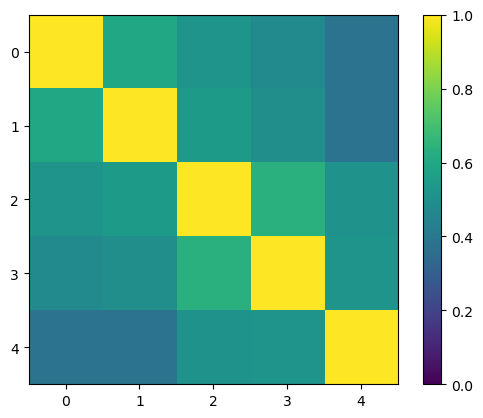

In [256]:
overlap_matrix = np.zeros((len(fdr_list), len(fdr_list)))
for idx, i in enumerate(fdr_list):
    for idx_j, j in enumerate(fdr_list):
        overlap_matrix[idx, idx_j] = nested_partition_overlap(state[i].get_bs(), state[j].get_bs())
overlap_matrix
plt.imshow(overlap_matrix, interpolation='nearest', vmin = 0., vmax = 1)
plt.colorbar()
plt.savefig(plot_folder + "network_overlap.pdf", dpi=300)

In [262]:
overlap_matrix


array([[1.        , 0.59656652, 0.5193133 , 0.47639485, 0.38197425],
       [0.59656652, 1.        , 0.54585153, 0.49565217, 0.37991266],
       [0.5193133 , 0.54585153, 1.        , 0.63436123, 0.50884956],
       [0.47639485, 0.49565217, 0.63436123, 1.        , 0.51769912],
       [0.38197425, 0.37991266, 0.50884956, 0.51769912, 1.        ]])

In [229]:
g[0.5]

<Graph object, undirected, with 213 vertices and 9041 edges, 5 internal vertex properties, 6 internal edge properties, at 0x1af248e90>

In [227]:

B = n_block[0.5]
N = len(g[0.5].get_vertices())
x = np.random.randint(0, B, N)
y = np.random.randint(0, B, N)
partition_overlap(x, y)

0.17370892018779344

In [205]:
def density(g):
    N = len(g.get_vertices())
    Et = (N * N - N)/2
    E = len(g.get_edges())
    density = E/Et
    return density

In [228]:
[density(g[i]) for i in fdr_list]

[0.40043405084595624,
 0.2168925502701745,
 0.12073700062007264,
 0.08410842412968376,
 0.049030029231995745]

In [ ]:
g_ref = Graph(tv_head_1e2, prune = True)
g = Graph(tv_head_1e1, prune = True)



g_1e1 = FilterByGraph(g, g_ref)
g_1e1.ep.z_s = g_1e1.new_edge_property("double", (2*np.arctanh(g_1e1.ep["spearman"].a)))


In [ ]:
state_head_1e1 = minimize_nested_blockmodel_dl(g_1e1, init_bs=bs_head, 
                                               state_args=dict(recs=[g_1e1.ep.z_s],
                                               rec_types=["real-normal"]))

NameError: name 'bs_head' is not defined

In [ ]:
mcmc_equilibrate(state_head_1e1, wait=100, nbreaks=1, mcmc_args=dict(niter=10))

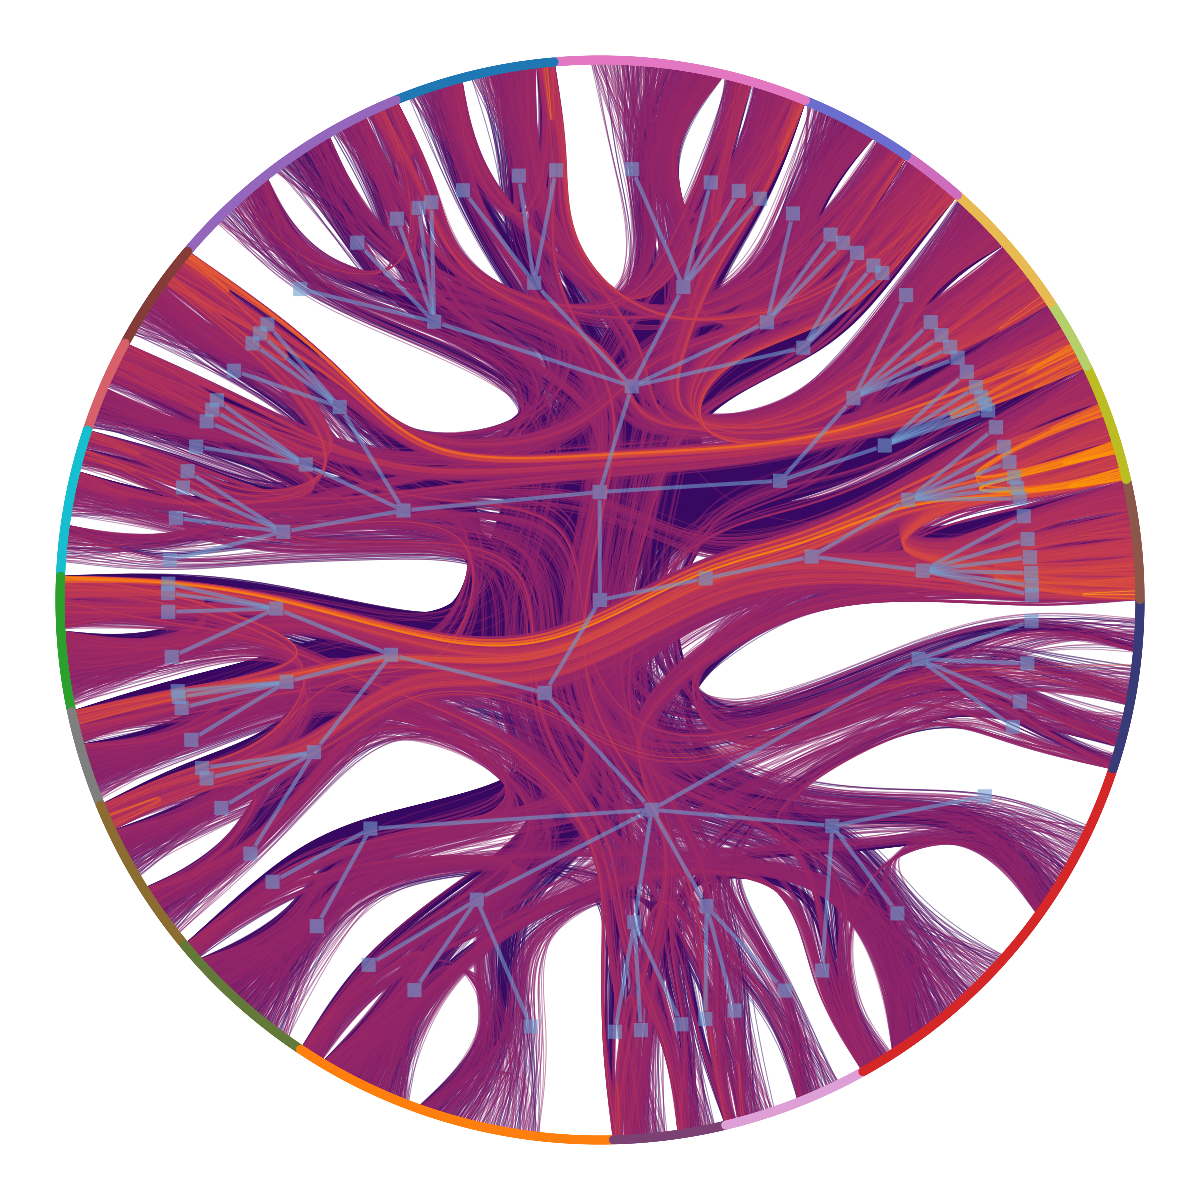

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fad8f5d7ad0, at 0x7fad8e0f0590>,
 <GraphView object, directed, with 5374 vertices and 5373 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fad753b0050, at 0x7fad753b0e90>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fad753b0050, at 0x7fad753b0f10>, False), at 0x7fad753b0050>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fad753b0050, at 0x7fad85ba9a10>)

In [ ]:
tv_head_1e2.vp.level_1 = tv_head_1e2.new_vertex_property("double", state_head_1e2.get_bs()[1][state_head_1e2.get_bs()[0]])

state_head_1e2.draw(
            eorder=tv_head_1e2.ep.z_s,
            #edge_pen_width = gf_head.ep.z_s,
            edge_color=prop_to_size(tv_head_1e2.ep.z_s, mi=-4, ma=4, power=1, log=False),
            ecmap=(mpl.inferno, .6), 
            edge_gradient=[], 
            vertex_size = 4,
            hvertex_size = 15,
            hedge_pen_width = 3,
            vertex_color = tv_head_1e2.vp.level_1,
            vertex_fill_color = tv_head_1e2.vp.level_1,
            subsample_edges = 30000)

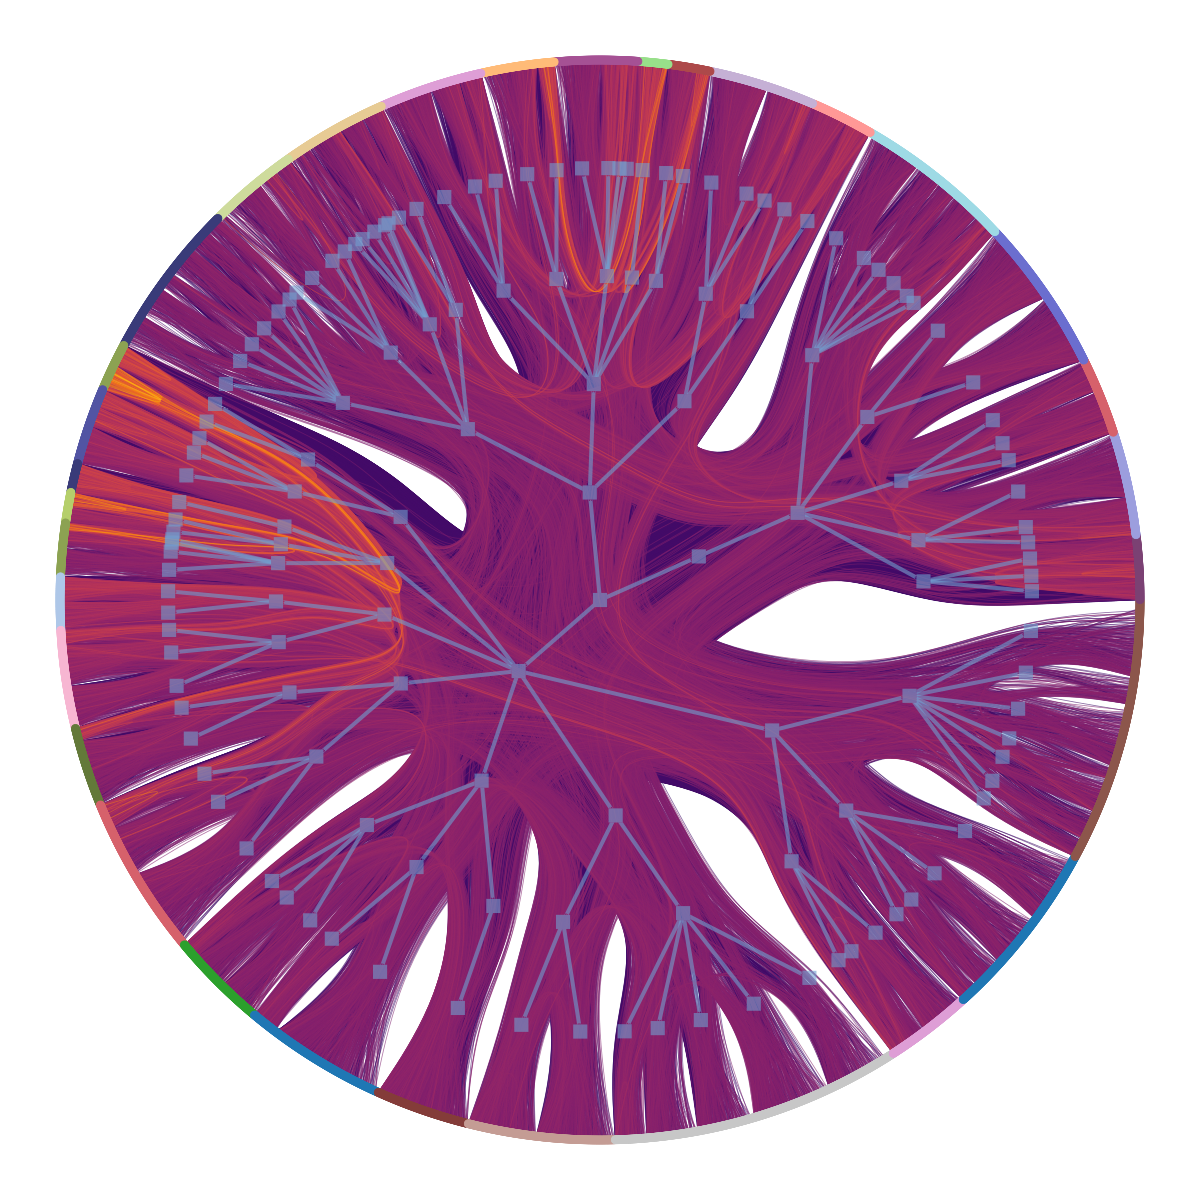

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fad8e0f8350, at 0x7fad7527fc90>,
 <GraphView object, directed, with 5409 vertices and 5408 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fad753c1dd0, at 0x7fad753bda50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fad753c1dd0, at 0x7fad753c0b50>, False), at 0x7fad753c1dd0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fad753c1dd0, at 0x7fad753c01d0>)

In [ ]:
g_1e1.vp.level_1 = g_1e1.new_vertex_property("double", state_head_1e1.get_bs()[1][state_head_1e1.get_bs()[0]])

state_head_1e1.draw(
            eorder=g_1e1.ep.z_s,
            #edge_pen_width = gf_head.ep.z_s,
            edge_color=prop_to_size(g_1e1.ep.z_s, mi=-4, ma=4, power=1, log=False),
            ecmap=(mpl.inferno, .6), 
            edge_gradient=[], 
            vertex_size = 4,
            hvertex_size = 10,
            hedge_pen_width = 2,
            vertex_color = g_1e1.vp.level_1,
            vertex_fill_color = g_1e1.vp.level_1,
            subsample_edges = 30000)

In [ ]:
partition_overlap(state_head_1e1.get_bs()[0], state_head_1e2.get_bs()[0], norm=True)

0.59456377114617